# CV Classification avec RandomForest Classifier

#### Jérémy LJ, Baptiste LB

Importer les modules nécessaires :

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import re
import nltk
import numpy as np

from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from statistics import mean 
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from scipy import stats

Lire le csv :

In [2]:
data = pd.read_csv("DataSet.csv")

In [3]:
data

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."
...,...,...
957,Testing,Computer Skills: â¢ Proficient in MS office (...
958,Testing,â Willingness to accept the challenges. â ...
959,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne..."
960,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...


## Traitement des données

Créer les fonctions d'application de ``BeautifulSoup`` sur les phrases :

In [4]:
def bs(sentence):
    #BeautifulSoup
    sentence = BeautifulSoup(sentence, "html.parser").get_text(separator=' ')
    #Suppression des caractères spéciaux
    sentence = re.sub('[^A-Za-z]+', " ", sentence)
    #Minuscules
    sentence = sentence.lower()
    
    return sentence

In [5]:
def bs2(sentence):
    #Fonction BeautifulSoup
    sentence = bs(sentence)
    #Conversion de string en liste
    sentence = sentence.split(" ")
    #Suppression des strings vides
    if '' in sentence: sentence.remove('')
        
    return sentence

Importer le ``tokenizer`` à partir de ``nltk`` :

In [6]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

Créer la fonction de traitement sur une colonne (suppression des caractères de ponctuation, ``tokenizer`` pour la séparation des phrases, fonction ``BeautifulSoup``, liste obtenu dans une nouvelle colonne) :

In [7]:
def bs_token(table, column_start, column_end):
    list_line = list()
    

    for line in table[column_start]:
        #Suppression de la ponctuation
        line = re.sub(r'(?<=[.,])(?=[^\s])', r' ', line)
        
        #Séparation des phrases
        line = tokenizer.tokenize(line)
        
        list_sentence = list()
        for sentence in line:
            #Vérification que l'élément n'est pas vide ou trop court
            if len(sentence) > 1:
                #Application de BeautifulSoup
                sentence = bs(sentence)
                list_sentence.append(sentence)
                
        #Retour en liste de listes
        list_line.append(list_sentence)
            
    #Nouvelle colonne
    table[column_end] = list_line

Application sur le dataset :

In [8]:
bs_token(data, "Resume", "Resume1")

In [9]:
data.head()

,Category,Resume,Resume1
0,Data Science,Skills * Programming Languages: Python (pandas...,[skills programming languages python pandas nu...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,[education details may to may b e uit rgpv dat...
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",[areas of interest deep learning control syste...
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,[skills r python sap hana tableau sap hana sql...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",[education details mca ymcaust faridabad harya...


In [10]:
data["Resume1"][0]

['skills programming languages python pandas numpy scipy scikit learn matplotlib sql java javascript jquery ',
 ' machine learning regression svm na ve bayes knn random forest decision trees boosting techniques cluster analysis word embedding sentiment analysis natural language processing dimensionality reduction topic modelling lda nmf pca neural nets ',
 ' database visualizations mysql sqlserver cassandra hbase elasticsearch d ',
 'js dc ',
 'js plotly kibana matplotlib ggplot tableau ',
 ' others regular expression html css angular logstash kafka python flask git docker computer vision open cv and understanding of deep learning ',
 'education details data science assurance associate data science assurance associate ernst young llp skill details javascript exprience months jquery exprience months python exprience monthscompany details company ernst young llp description fraud investigations and dispute services assurance technology assisted review tar technology assisted review assis

## Entraînement du modèle ``Word2Vec``

Séparation en données d'entraînement et de test :

In [11]:
train, test = train_test_split(data, test_size=0.2)

In [12]:
display(train.shape, test.shape)

(769, 3)

(193, 3)

Création d'une fonction qui récupère toutes les phrases d'une colonne, sans tenir compte des cellules :

In [13]:
def w2v_preparation(column):
    sentence_list = list()
    for cell in column:
        for sentence in cell:
            sentence = sentence.split()
            sentence_list.append(sentence)
    return sentence_list

Application de cette fonction sur les données ``train`` transformé :

In [14]:
sentence_list = w2v_preparation(train["Resume1"])

In [15]:
len(sentence_list)

18740

In [16]:
sentence_list[0]

['computer', 'skills', 'yes']

Modèle ``Word2Vec`` entraîné avec cette liste de phrases :

In [17]:
w2v = Word2Vec(sentences=sentence_list, sample=0.0001, size=300, window=10, workers=5, min_count=40)

In [18]:
w2v.wv.vectors.shape

(1237, 300)

Fonctions de création de matrices de vecteurs à partir des données nettoyées :

In [19]:
def vector_mean(w_list, model, features_length):
    mean_list = list()
    for feature in range(features_length):
        feature_list = list()
        for word in w_list:
            try:
                #Application du modèle sur le mot
                feature_list.append(model.wv[word][feature])
            except:
                #Vecteur nul
                feature_list.append(0)
        mean_list.append(mean(feature_list))
    
    return mean_list

In [20]:
def vector_matrix(s_list, model, features_length):
    mean_list_list = list()
    for sentence in s_list:
        #Application de BeautifulSoup
        word_list = bs2(sentence)
        #Transformation en liste de vecteurs
        mean_list_list.append(vector_mean(word_list, model, features_length))
        
    return np.matrix(mean_list_list)

Application sur ``train`` et ``test`` :

In [22]:
matrix_train = vector_matrix(train["Resume"], w2v, 300)

In [23]:
display(matrix_train[0])
display(len(matrix_train))

matrix([[ 0.10989377,  0.0478465 ,  0.00869697, -0.09834973,  0.07006988,
          0.01357682,  0.1408197 , -0.0504569 ,  0.0367466 ,  0.25371155,
         -0.21007803,  0.30910733,  0.18670915,  0.09792036, -0.16399549,
         -0.0779568 , -0.09611756,  0.02661505, -0.1206646 ,  0.2088363 ,
          0.02002417,  0.16230746,  0.07936549,  0.06387461, -0.15431313,
         -0.01029988,  0.02588046, -0.06593807,  0.16012634,  0.11354125,
          0.05419782, -0.0059617 , -0.05540553, -0.1185585 ,  0.20513757,
         -0.05809126,  0.18523541, -0.15815625,  0.09606987, -0.09653269,
          0.12714808,  0.0104794 , -0.03212498,  0.01246128, -0.04805077,
          0.07405654,  0.09138209,  0.04369773,  0.11987924, -0.19534782,
          0.02563473, -0.08975949, -0.16166523,  0.10949796, -0.35279053,
         -0.09621283,  0.08230894, -0.02727171, -0.13577418,  0.03975465,
          0.1127595 ,  0.12092363, -0.15338056, -0.09109111,  0.11228835,
         -0.10008512,  0.03817581,  0.

769

In [24]:
matrix_test = vector_matrix(test["Resume"], w2v, 300)

In [25]:
display(len(matrix_test))

193

In [26]:
matrix_train.shape

(769, 300)

## Application de ``RandomForestClassifier``

Entraînement sur la matrice de vecteurs :

In [27]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(matrix_train, train["Category"])

RandomForestClassifier()

Prédiction sur la matrice de test :

In [28]:
prediction = rfc.predict(matrix_test)

Comparaison avec les catégories initiales :

In [29]:
test["Prediction"] = prediction

<ipython-input-29-25269a8e713a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Prediction"] = prediction


In [30]:
test

,Category,Resume,Resume1,Prediction
392,Java Developer,TECHNICAL STRENGTHS Computer Language Java/J2E...,[technical strengths computer language java j ...,Java Developer
666,Network Security Engineer,Communication Skills My writing skills in Engl...,[communication skills my writing skills in eng...,Network Security Engineer
721,Database,Technical Expertise Operating Systems Microsof...,[technical expertise operating systems microso...,Database
172,Web Designing,"Technical Skills Web Technologies: Angular JS,...",[technical skills web technologies angular js ...,Web Designing
485,Electrical Engineering,Education Details \r\nJanuary 2012 to January ...,[education details january to january b e elec...,Electrical Engineering
...,...,...,...,...
951,Testing,â Willingness to accept the challenges. â ...,"[ willingness to accept the challenges , posi...",Testing
634,DevOps Engineer,Software Proficiency: â¢ Languages: Basics of...,[software proficiency languages basics of c sq...,DevOps Engineer
274,Health and fitness,SKILLS: Computer: â¢ Can easily operate in Op...,[skills computer can easily operate in operati...,Health and fitness
299,Civil Engineer,COMPUTER KNOWLEDGE â¢ Drafting tools: AutoCAD...,"[computer knowledge drafting tools autocad , ...",Civil Engineer


In [31]:
display(len(test[test["Category"] == test["Prediction"]]))
display(len(test[test["Category"] != test["Prediction"]]))

193

0

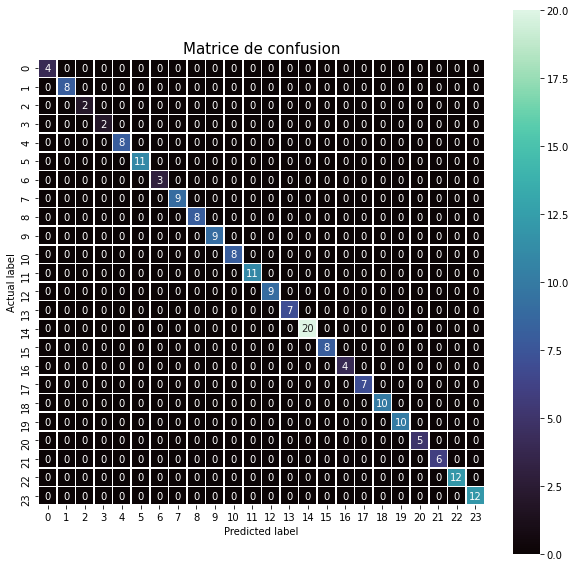

In [34]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

c_m = confusion_matrix(test["Category"], prediction)
plt.figure(figsize=(10,10))
sns.heatmap(c_m, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'mako');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Matrice de confusion", size = 15)
plt.show()

Observation : Une erreur est répétée deux fois.

In [33]:
display("Longueur du dataset :", len(data["Resume"]))
display("Longueur du dataset :", len(data["Resume"].unique()))

'Longueur du dataset :'

962

'Longueur du dataset :'

166

Observation : Le dataset contient énormément de doublons, le nombre de valeurs uniques est peu élevé.

## Affichage ``MatPlotLib``

Comparaison des fréquences de catégories entre le dataset originel et le dataset réduit à ses CV uniques :

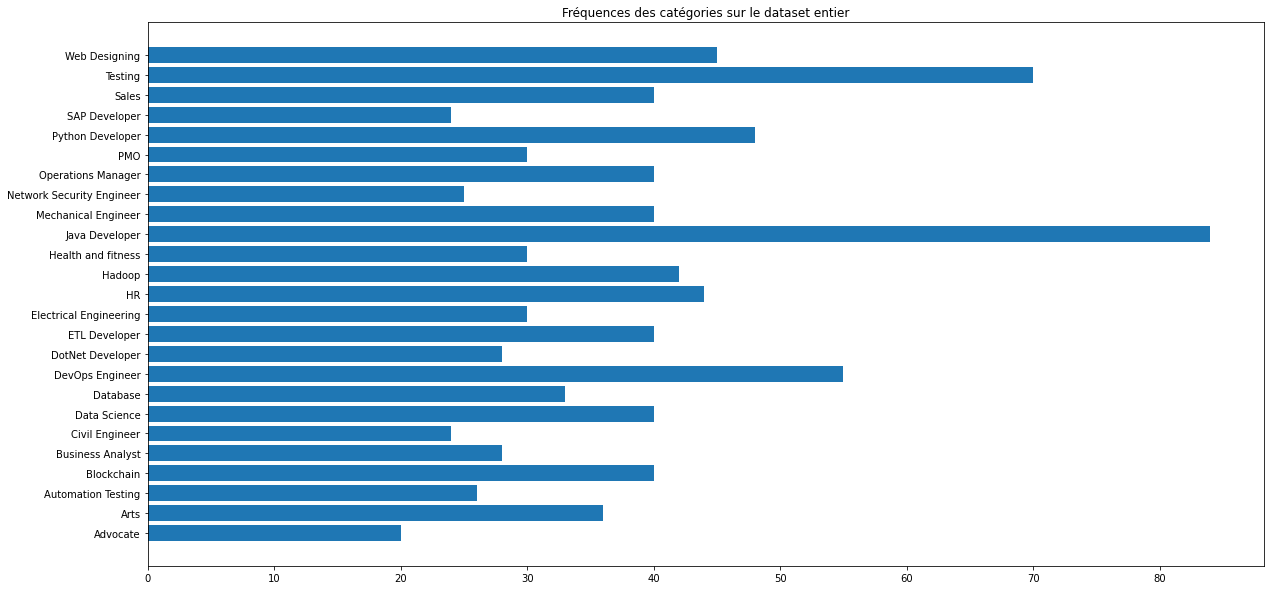

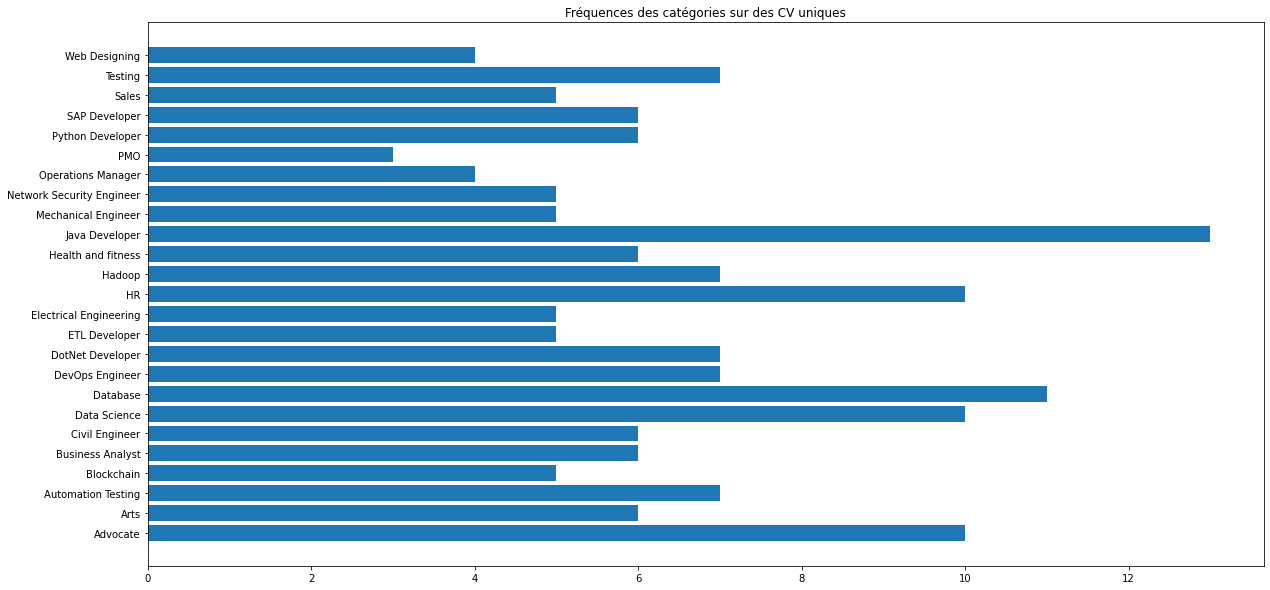

In [69]:
set_category = list(sorted(set(data["Category"])))
frequency_list = list()
for category in set_category:
    frequency = len(data[data["Category"] == category])
    frequency_list.append(frequency)

plt.figure(figsize=(20,10))
plt.title("Fréquences des catégories sur le dataset entier")
plt.barh(set_category, frequency_list)

frequency_list2 = list()

unique_data = data.groupby("Resume").first()

for category in set_category:
    frequency2 = len(unique_data[unique_data["Category"] == category])
    frequency_list2.append(frequency2)

plt.figure(figsize=(20,10))
plt.title("Fréquences des catégories sur des CV uniques")
plt.barh(set_category, frequency_list2)

plt.show()

## Ratio des CV répétés

In [70]:
comp_data = pd.DataFrame(list(zip(set_category, frequency_list, frequency_list2)), 
               columns =['Category', 'Frequency', 'Unique Frequency']) 

In [71]:
comp_data['Ratio'] = comp_data['Frequency'] / comp_data['Unique Frequency']

In [74]:
comp_data.sort_values(by=['Ratio'], ascending=False)

,Category,Frequency,Unique Frequency,Ratio
24,Web Designing,45,4,11.250000
23,Testing,70,7,10.000000
18,Operations Manager,40,4,10.000000
19,PMO,30,3,10.000000
20,Python Developer,48,6,8.000000
10,ETL Developer,40,5,8.000000
16,Mechanical Engineer,40,5,8.000000
22,Sales,40,5,8.000000
3,Blockchain,40,5,8.000000
8,DevOps Engineer,55,7,7.857143


## Affichage ``WordCloud``

Liste de tous les mots de ``train`` :

In [34]:
words_list = list()
for cell in (train["Resume1"]):
    for sentence in cell:
        for word in sentence.split():
            words_list.append(word)

In [36]:
len(set(words_list))

7244

Identifier les mots qui apparaissent plus de 500 fois dans les données d'entraînement :

In [37]:
c = Counter(words_list)
most_common_list = list()

for word in set(words_list):
    if c[word] > 500:
        most_common_list.append(word)

Pour chaque catégorie, créer un ``WordCloud`` en filtrant les mots les plus communs identifiés par la liste précédente :

==== Java Developer ===


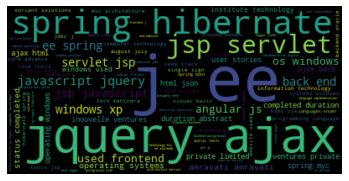

==== ETL Developer ===


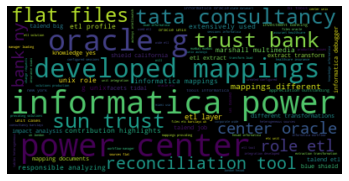

==== DevOps Engineer ===


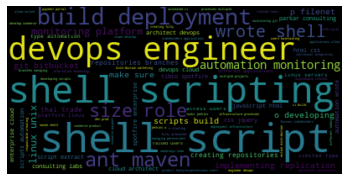

==== Web Designing ===


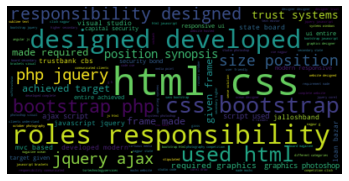

==== Civil Engineer ===


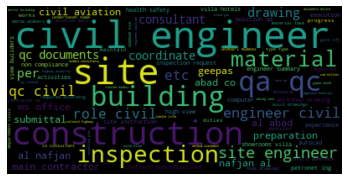

==== Mechanical Engineer ===


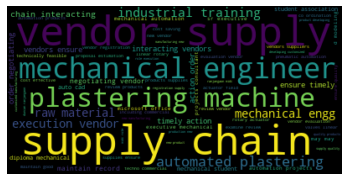

==== Blockchain ===


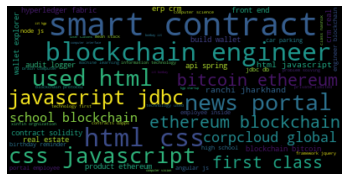

==== Sales ===


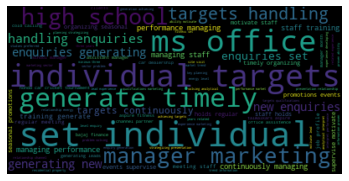

==== Automation Testing ===


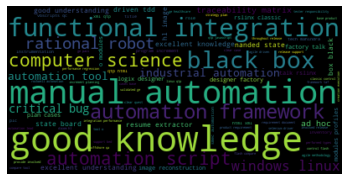

==== HR ===


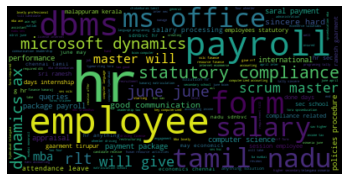

==== Testing ===


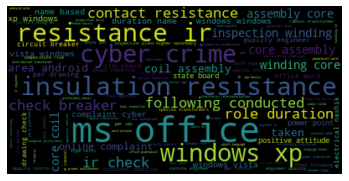

==== Health and fitness ===


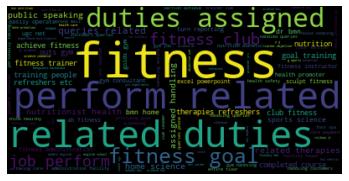

==== Data Science ===


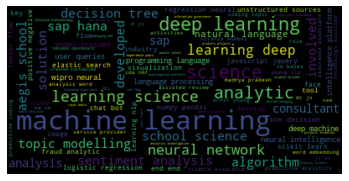

==== PMO ===


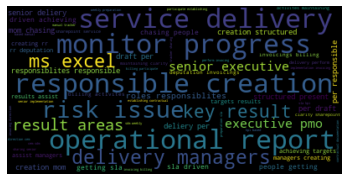

==== Hadoop ===


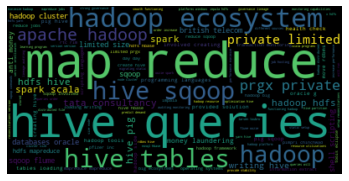

==== Python Developer ===


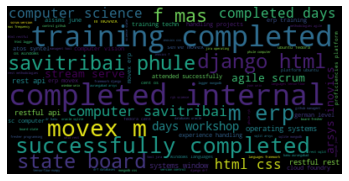

==== Business Analyst ===


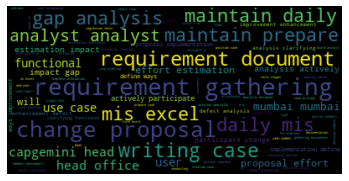

==== Electrical Engineering ===


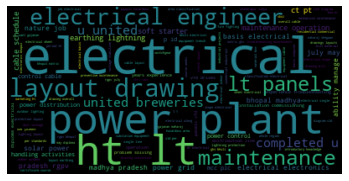

==== Network Security Engineer ===


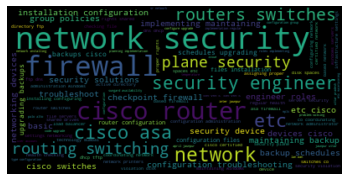

==== DotNet Developer ===


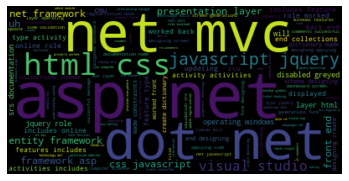

==== Advocate ===


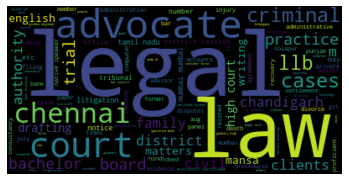

==== SAP Developer ===


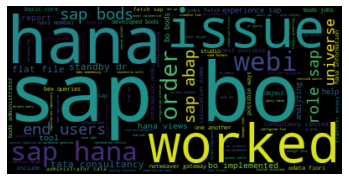

==== Database ===


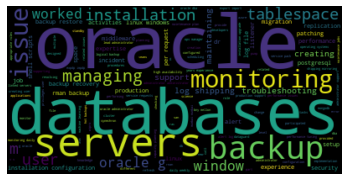

==== Operations Manager ===


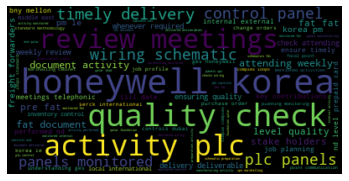

==== Arts ===


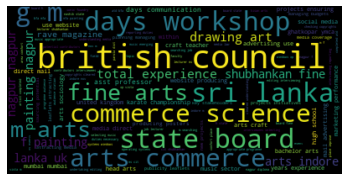

In [38]:
for category in set(train["Category"]):
    #Imprimer la catégorie
    print("====", category, "===")
    
    #Obtenir le texte
    text = list(train["Resume1"][train["Category"] == category])
    text2 = list()
    for cell in text:
        for sentence in cell:
            for word in sentence.split():
                #N'ajouter le mot que s'il n'est pas dans la liste des mots les plus communs
                if word not in most_common_list:
                    text2.append(word)
    #Supprimer les caractères de liste
    text2 = str(text2).replace("[", "").replace("]", "").replace("'", "").replace(",", "")
    
    #Générer le WordCloud
    wordcloud = WordCloud().generate(text2)
    #L'afficher
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()